In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

In [54]:
df = pd.read_csv("trades_sorted_1m.csv")

In [55]:
df.head()

,Unnamed: 0,TICKET,LOGIN,SYMBOL,DIGITS,CMD,VOLUME,OPEN_TIME,OPEN_PRICE,SL,...,TAXES,COMMENT,INTERNAL_ID,MARGIN_RATE,TIMESTAMP,MAGIC,GW_VOLUME,GW_OPEN_PRICE,GW_CLOSE_PRICE,MODIFY_TIME
0,453515,2085443811,1162,USDJPY,2,1,10,2005-03-18 19:03:57,104.6600,0.0,...,0.0,NaN,0,0.0,1259418114,0,0,0,0,2022-11-28 18:03:30
1,453518,2085443814,1162,USDJPY,2,1,50,2005-03-21 05:15:39,104.9900,0.0,...,0.0,NaN,0,0.0,1259418114,0,0,0,0,2022-11-28 18:03:30
2,453517,2085443813,1162,GBPUSD,4,0,20,2005-03-21 05:37:03,1.9150,0.0,...,0.0,NaN,0,0.0,1259418114,0,0,0,0,2022-11-28 18:03:30
3,453516,2085443812,1162,USDJPY,2,1,20,2005-03-21 05:37:05,104.8700,0.0,...,0.0,NaN,0,0.0,1259418114,0,0,0,0,2022-11-28 18:03:30
4,453521,2085443817,1162,GBPUSD,4,0,20,2005-03-21 05:54:45,1.9138,0.0,...,0.0,NaN,0,0.0,1259418114,0,0,0,0,2022-11-28 18:03:30


In [56]:
df= df[df['MAGIC'] == 0]
df= df[["TICKET", "LOGIN", "SYMBOL", "PROFIT", "OPEN_TIME"]]
df= df[df['SYMBOL'].notnull()]

traders_count= df.groupby(['LOGIN']).agg({'TICKET':'count'})
traders_count= traders_count[traders_count['TICKET'] >= 100].reset_index()
traders= traders_count['LOGIN'].tolist()
filter_df= df[df['LOGIN'].isin(traders)]
filter_df

,TICKET,LOGIN,SYMBOL,PROFIT,OPEN_TIME
0,2085443811,1162,USDJPY,-70.21,2005-03-18 19:03:57
1,2085443814,1162,USDJPY,42.89,2005-03-21 05:15:39
2,2085443813,1162,GBPUSD,20.00,2005-03-21 05:37:03
3,2085443812,1162,USDJPY,17.17,2005-03-21 05:37:05
4,2085443817,1162,GBPUSD,20.00,2005-03-21 05:54:45
...,...,...,...,...,...
999991,2094826117,72067,EURUSD,-9.39,2011-08-17 14:31:31
999992,2094826123,72067,EURUSD,-10.23,2011-08-17 14:32:04
999993,2094826142,518298,USDCHF,1.63,2011-08-17 14:34:39
999997,2094814634,566832,EURUSD,-10.93,2011-08-17 14:37:44


In [57]:
filter_df['loss'] = np.where(filter_df['PROFIT']<= 0, 1, 0)
filter_df['win'] = np.where(filter_df['PROFIT']> 0, 1, 0)

In [58]:
train, test = train_test_split(filter_df, test_size=0.2)

<AxesSubplot:ylabel='Density'>

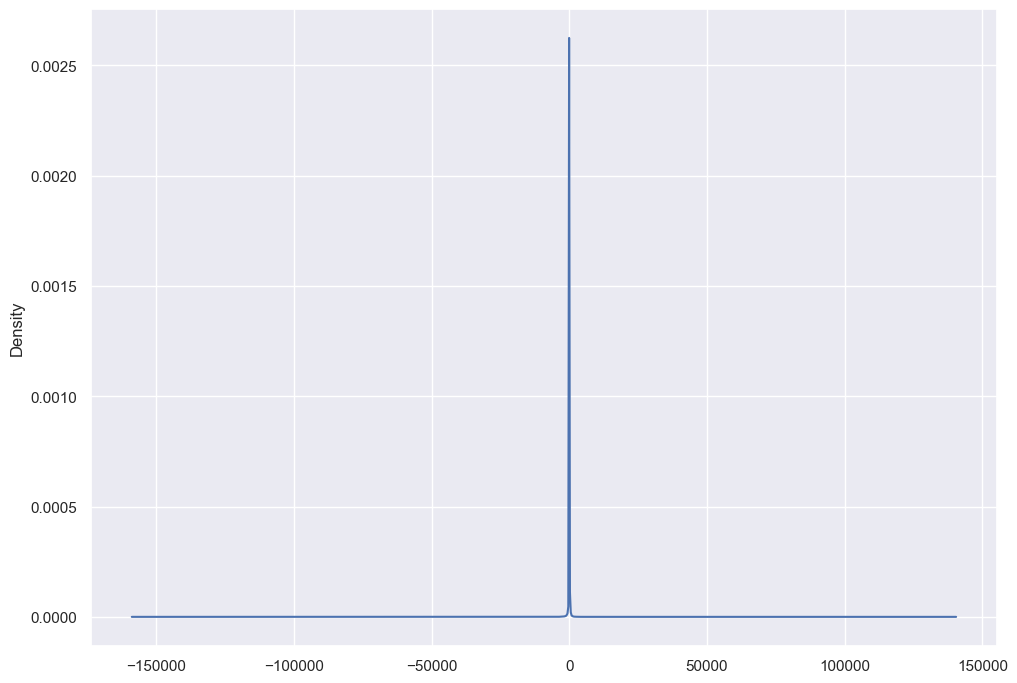

In [59]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
train['PROFIT'].plot.kde()

In [60]:
trader_symbol_grouping= train.groupby(['LOGIN', 'SYMBOL']).agg({'TICKET': 'count', 'PROFIT': 'sum', \
                'loss': 'sum','win': 'sum'}).reset_index()

trader_symbol_grouping['win_rate']= trader_symbol_grouping['win'] / (trader_symbol_grouping['loss'] + \
                                                                     trader_symbol_grouping['win'])

<AxesSubplot:ylabel='Density'>

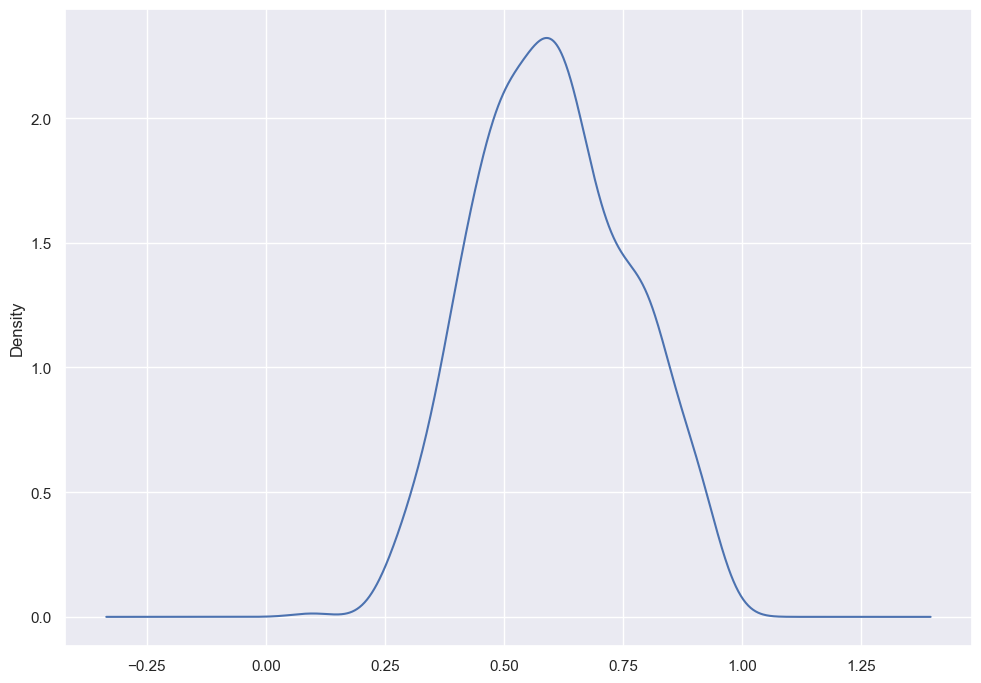

In [61]:
trader_grouping= trader_symbol_grouping.groupby(['LOGIN']).agg({'TICKET': 'count', 'PROFIT': 'sum', \
                'loss': 'sum','win': 'sum'}).reset_index()

trader_grouping['win_rate']= trader_grouping['win'] / (trader_grouping['loss'] + \
                                                                     trader_grouping['win'])

trader_grouping['win_rate'].plot.kde()

<AxesSubplot:ylabel='Density'>

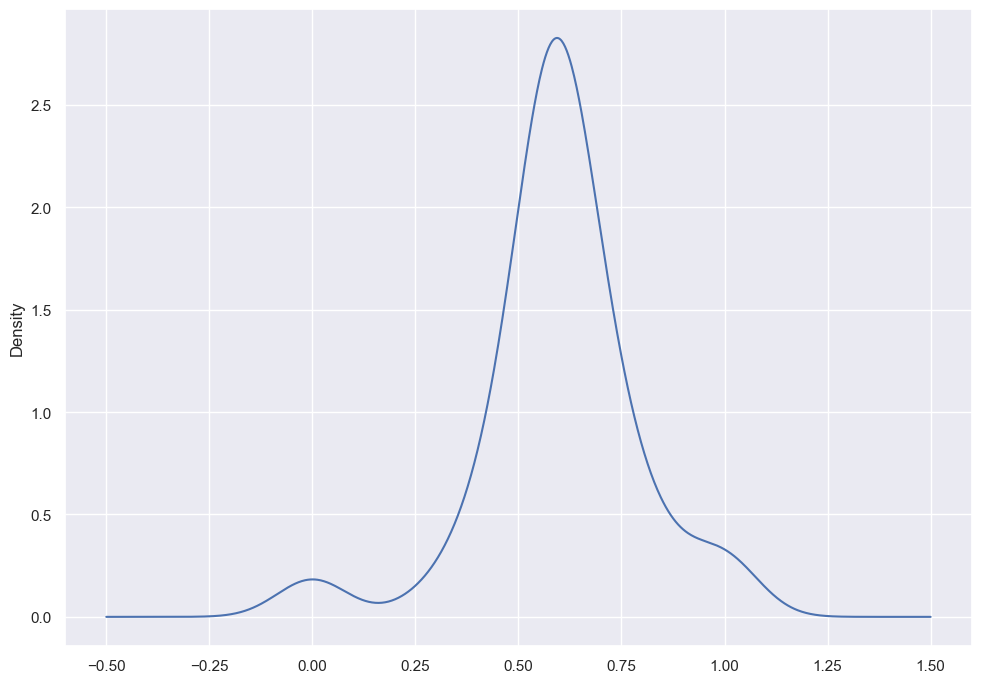

In [62]:
symbol_grouping= train.groupby(['SYMBOL']).agg({'TICKET': 'count', 'PROFIT': 'sum', \
                'loss': 'sum','win': 'sum'}).reset_index()

symbol_grouping['win_rate']= symbol_grouping['win'] / (symbol_grouping['loss'] + \
                                                                     symbol_grouping['win'])

symbol_grouping['win_rate'].plot.kde()

# Trader Performance

In [63]:
table1 = trader_symbol_grouping.pivot('LOGIN', 'SYMBOL', 'win_rate')
table1.to_csv('trader_symbol_performance')

In [64]:
train = train.sort_values(by=['LOGIN','SYMBOL','OPEN_TIME'], ascending=[True, True, True]).dropna(subset=['SYMBOL']) #Sorting the values

unique_accid = train['LOGIN'].unique().tolist() #Getting the unique account id's

len(unique_accid)

696

# Back Testing Profit

In [65]:
agg_func_math = {
    'PROFIT':
    ['sum', 'mean', 'median', 'min', 'max', 'std', 'var', 'mad', 'prod', 'count']
}
stats = train.groupby(['LOGIN', 'SYMBOL']).agg(agg_func_math)

stats

PROFIT                                                 \
                   sum       mean  median     min     max         std   
LOGIN   SYMBOL                                                          
1162    EURGBP  -47.29 -47.290000 -47.290  -47.29  -47.29         NaN   
        EURUSD -726.00 -10.835821   1.000 -640.00   76.00   85.642774   
        GBPJPY   49.46  16.486667  18.620    2.90   27.94   12.655581   
        GBPUSD -967.00 -29.303030  20.000 -980.00  100.00  201.742330   
        USDCHF    8.12   8.120000   8.120    8.12    8.12         NaN   
...                ...        ...     ...     ...     ...         ...   
6866968 NZDUSD   -4.00  -4.000000  -4.000   -4.00   -4.00         NaN   
        USDCAD  -12.95  -3.237500  -6.055   -9.71    8.87    8.265944   
        USDCHF   -2.51  -0.627500  -0.115   -6.89    4.61    5.353008   
        USDJPY    3.01   0.130870   0.000  -61.05   48.33   21.929342   
        XAUUSD -254.57 -84.856667 -75.600 -135.00  -43.97   46.215578   

                                                               
                         var         mad           prod count  
LOGIN   SYMBOL                                                 
1162    EURGBP           NaN    0.000000     -47.290000     1  
        EURUSD   7334.684758   29.676097       0.000000    67  
        GBPJPY    160.163733    9.057778    1508.704120     3  
        GBPUSD  40699.967803  104.677686       0.000000    33  
        USDCHF           NaN    0.000000       8.120000     1  
...                      ...         ...            ...   ...  
6866968 NZDUSD           NaN    0.000000      -4.000000     1  
        USDCAD     68.325825    6.053750   -3131.172534     4  
        USDCHF     28.654692    4.407500     297.967765     4  
        USDJPY    480.896026   13.300907      -0.000000    23  
        XAUUSD   2135.879633   33.428889 -448757.820000     3  

[6603 rows x 10 columns]

In [66]:
bad_traders = stats[(stats[('PROFIT', 'mean')] < 0) & (stats[('PROFIT', 'median')] < 0) & (stats[('PROFIT', 'sum')] < 0) & (stats[('PROFIT', 'count')] > 100)]
good_traders = stats[(stats[('PROFIT', 'mean')] > 0) & (stats[('PROFIT', 'median')] > 0) & (stats[('PROFIT', 'sum')] > 0) & (stats[('PROFIT', 'count')] > 100)]

bad_traders

PROFIT                                                   \
                    sum       mean  median      min      max         std   
LOGIN  SYMBOL                                                              
22093  EURUSD  -1432.00 -13.018182 -40.000  -490.00   820.00  175.307383   
31306  GBPUSD  -1243.00  -8.398649  -2.000  -330.00   475.00  101.628558   
51023  EURUSD -17791.84  -2.656291  -0.200 -3690.00  3258.00   67.444484   
       GBPUSD  -2468.60  -4.416100  -0.300  -400.00   118.00   31.046342   
53050  EURJPY   -806.46  -6.556585 -49.500  -374.90   550.00  194.559766   
...                 ...        ...     ...      ...      ...         ...   
570406 GBPUSD  -1377.58  -7.871886 -13.100  -305.00   675.20   99.776247   
571262 GBPUSD   -177.37  -1.597928  -1.570   -52.80    93.17   14.045798   
571758 EURJPY  -4594.30 -21.468692  -1.265  -624.73   456.63  129.868649   
       XAUUSD  -5356.52 -19.987015  -4.800 -1226.00   500.00  141.119402   
572177 EURUSD   -833.34  -5.827552  -5.300  -125.00    34.50   21.192085   

                                                              
                        var         mad           prod count  
LOGIN  SYMBOL                                                 
22093  EURUSD  30732.678565  109.707769   0.000000e+00   110  
31306  GBPUSD  10328.363808   57.574050  -0.000000e+00   148  
51023  EURUSD   4548.758480   12.185610  -0.000000e+00  6698  
       GBPUSD    963.875332   11.029181  -0.000000e+00   559  
53050  EURJPY  37853.502388  165.014396   0.000000e+00   123  
...                     ...         ...            ...   ...  
570406 GBPUSD   9955.299522   54.004430  -0.000000e+00   175  
571262 GBPUSD    197.284455    6.491603  -0.000000e+00   111  
571758 EURJPY  16865.865926   75.962937 -1.042057e+306   214  
       XAUUSD  19914.685712   80.438966   0.000000e+00   268  
572177 EURUSD    449.104479   14.217153 -6.942675e+138   143  

[160 rows x 10 columns]

In [67]:
good_traders

PROFIT                                                     \
                    sum       mean  median       min      max          std   
LOGIN  SYMBOL                                                                
1396   USDCAD  14769.93  11.797069   26.19 -16696.67  3513.45   588.294657   
51040  EURJPY   2412.89  14.110468   41.58  -1031.19   224.98   165.694025   
51765  EURJPY   2068.84   8.879142   12.41   -746.62   164.19    57.920260   
       EURUSD    999.00   2.485075    6.00   -735.00  1180.00   112.824234   
       USDCHF    473.51   1.997932   15.26   -676.11   126.69    82.478057   
...                 ...        ...     ...       ...      ...          ...   
570668 EURCHF   2206.40  21.013333   22.30  -1713.21  1306.29   395.941838   
570943 EURUSD     93.20   0.733858    2.68    -76.92    39.20    14.853356   
571129 EURUSD    324.81   2.370876    1.63    -10.72    15.36     2.545644   
572015 EURUSD     24.23   0.031305    0.65    -67.86    15.85     6.569244   
572273 XAUUSD  10111.22  93.622407  152.00  -4940.00  5143.00  1188.681848   

                                                              
                        var         mad           prod count  
LOGIN  SYMBOL                                                 
1396   USDCAD  3.460906e+05  117.275995   0.000000e+00  1252  
51040  EURJPY  2.745451e+04   93.662101  -0.000000e+00   171  
51765  EURJPY  3.354757e+03   16.082440 -4.304205e+268   233  
       EURUSD  1.272931e+04   38.924779   0.000000e+00   402  
       USDCHF  6.802630e+03   31.548369  -0.000000e+00   237  
...                     ...         ...            ...   ...  
570668 EURCHF  1.567699e+05  249.145016 -4.460087e+219   105  
570943 EURUSD  2.206222e+02    8.927920   1.963878e+86   127  
571129 EURUSD  6.480302e+00    1.556131   7.596904e+38   137  
572015 EURUSD  4.315497e+01    2.099509   0.000000e+00   774  
572273 XAUUSD  1.412965e+06  555.702243  1.209277e+240   108  

[149 rows x 10 columns]

In [68]:
badtraders = set()
for i, x in bad_traders.iterrows():
    _id = f'{i[0]}/{i[1]}'
    badtraders.add(_id)
    
badtraders

{'120799/EURUSD',
 '120799/GBPUSD',
 '122026/GBPJPY',
 '122321/EURUSD',
 '123248/EURUSD',
 '124099/EURUSD',
 '22093/EURUSD',
 '31306/GBPUSD',
 '502111/GBPUSD',
 '504908/GBPJPY',
 '507854/GBPUSD',
 '51023/EURUSD',
 '51023/GBPUSD',
 '517179/EURUSD',
 '518093/AUDUSD',
 '518093/EURUSD',
 '518093/GBPUSD',
 '518093/USDJPY',
 '518753/EURJPY',
 '518753/EURUSD',
 '518753/GBPCHF',
 '518753/GBPJPY',
 '518753/GBPUSD',
 '518836/GBPUSD',
 '523784/EURUSD',
 '523944/GBPUSD',
 '53050/EURJPY',
 '53170/EURJPY',
 '53170/EURUSD',
 '53170/GBPUSD',
 '53342/USDJPY',
 '53342/USDMXN',
 '53590/USDJPY',
 '53709/AUDJPY',
 '53709/GBPJPY',
 '53709/USDCHF',
 '53933/EURJPY',
 '53933/EURUSD',
 '53933/GBPUSD',
 '54084/EURUSD',
 '54084/GBPJPY',
 '54084/GBPUSD',
 '54363/EURJPY',
 '545392/EURUSD',
 '545392/GBPJPY',
 '545392/GBPUSD',
 '546460/AUDUSD',
 '546460/EURUSD',
 '546460/GBPUSD',
 '54819/GBPJPY',
 '54819/GBPUSD',
 '54819/XAGUSD',
 '550958/EURUSD',
 '551221/EURUSD',
 '551576/GBPJPY',
 '551576/GBPUSD',
 '551683/AUDUSD'

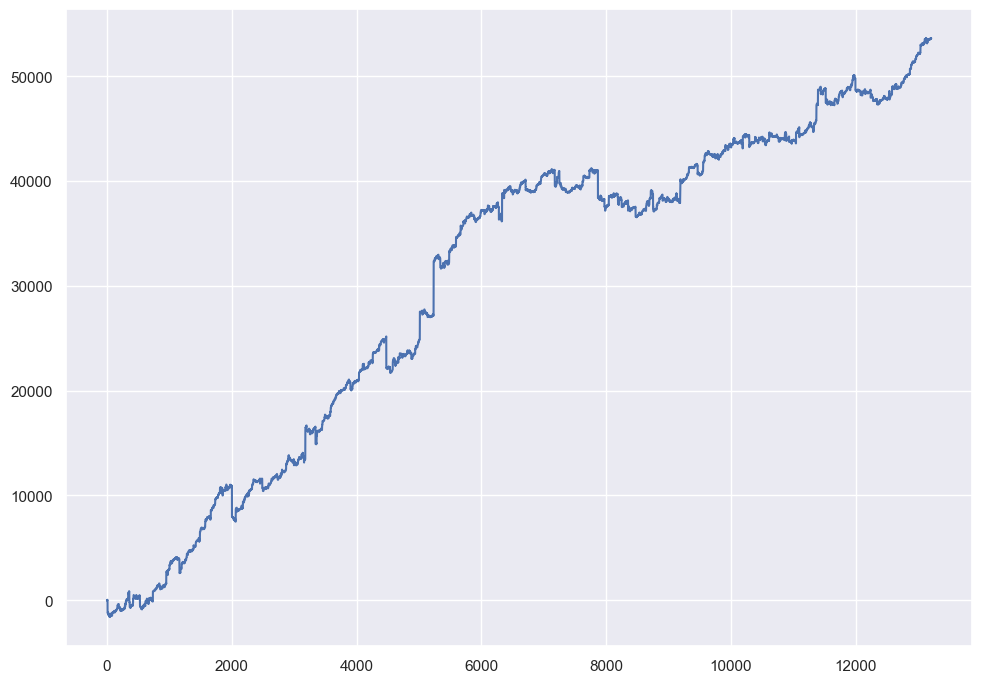

In [69]:
equity = 0
history = []
history.append(equity)

for i, x in test.iterrows():
    _id = f"{x['LOGIN']}/{x['SYMBOL']}"
    if _id in badtraders:
        equity += (-1 * x['PROFIT'])
        history.append(equity)
plt.plot(history)

In [70]:
(len(history) / len(test)) * 100

12.101694915254237

In [71]:
goodtraders = set()
for i, x in good_traders.iterrows():
    _id = f'{i[0]}/{i[1]}'
    goodtraders.add(_id)

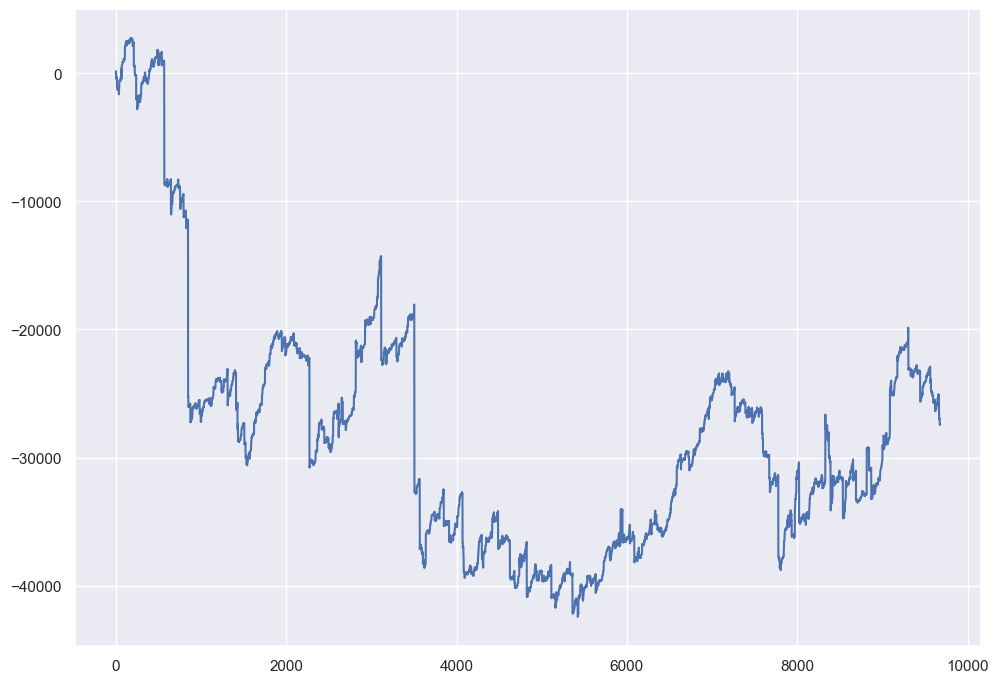

In [72]:
equity = 0
history = []
history.append(equity)

for i, x in test.iterrows():
    _id = f"{x['LOGIN']}/{x['SYMBOL']}"
    if _id in goodtraders:
        equity += (1 * x['PROFIT'])
        history.append(equity)
plt.plot(history)

In [73]:
(len(history) / len(test)) * 100

8.866697205680255

# Back Test for Win Rate

In [74]:
train.head()

,TICKET,LOGIN,SYMBOL,PROFIT,OPEN_TIME,loss,win
3119,2085460744,1162,EURGBP,-47.29,2006-09-27 10:08:37,1,0
45,2085444035,1162,EURUSD,-4.00,2005-07-13 08:45:04,1,0
90467,2085502218,1162,EURUSD,5.00,2008-08-06 15:32:08,0,1
98570,2085502819,1162,EURUSD,2.00,2008-09-03 03:04:27,0,1
99801,2085502930,1162,EURUSD,40.00,2008-09-05 11:23:11,0,1


In [75]:
agg_func_math = {
    'win_rate':
    ['sum', 'mean', 'median', 'min', 'max', 'std', 'var', 'mad', 'prod', 'count']
}
stats1 = trader_symbol_grouping.groupby(['LOGIN', 'SYMBOL']).agg(agg_func_math)

stats1

win_rate                                                       \
                     sum      mean    median       min       max std var  mad   
LOGIN   SYMBOL                                                                  
1162    EURGBP  0.000000  0.000000  0.000000  0.000000  0.000000 NaN NaN  0.0   
        EURUSD  0.641791  0.641791  0.641791  0.641791  0.641791 NaN NaN  0.0   
        GBPJPY  1.000000  1.000000  1.000000  1.000000  1.000000 NaN NaN  0.0   
        GBPUSD  0.787879  0.787879  0.787879  0.787879  0.787879 NaN NaN  0.0   
        USDCHF  1.000000  1.000000  1.000000  1.000000  1.000000 NaN NaN  0.0   
...                  ...       ...       ...       ...       ...  ..  ..  ...   
6866968 NZDUSD  0.000000  0.000000  0.000000  0.000000  0.000000 NaN NaN  0.0   
        USDCAD  0.250000  0.250000  0.250000  0.250000  0.250000 NaN NaN  0.0   
        USDCHF  0.500000  0.500000  0.500000  0.500000  0.500000 NaN NaN  0.0   
        USDJPY  0.478261  0.478261  0.478261  0.478261  0.478261 NaN NaN  0.0   
        XAUUSD  0.000000  0.000000  0.000000  0.000000  0.000000 NaN NaN  0.0   

                                
                    prod count  
LOGIN   SYMBOL                  
1162    EURGBP  0.000000     1  
        EURUSD  0.641791     1  
        GBPJPY  1.000000     1  
        GBPUSD  0.787879     1  
        USDCHF  1.000000     1  
...                  ...   ...  
6866968 NZDUSD  0.000000     1  
        USDCAD  0.250000     1  
        USDCHF  0.500000     1  
        USDJPY  0.478261     1  
        XAUUSD  0.000000     1  

[6603 rows x 10 columns]

In [76]:
bad_traders1 = stats1[(stats1[('win_rate', 'sum')] < 0.5)]# & (stats1[('PROFIT', 'median')] < 0) & (stats1[('PROFIT', 'sum')] < 0) & (stats1[('PROFIT', 'count')] > 100)]
good_traders1 = stats1[(stats1[('win_rate', 'sum')] >= 0.5)]# & (stats1[('PROFIT', 'median')] > 0) & (stats1[('PROFIT', 'sum')] > 0) & (stats1[('PROFIT', 'count')] > 100)]

In [85]:
bad_traders1

win_rate                                                       \
                     sum      mean    median       min       max std var  mad   
LOGIN   SYMBOL                                                                  
1162    EURGBP  0.000000  0.000000  0.000000  0.000000  0.000000 NaN NaN  0.0   
1396    AUDJPY  0.000000  0.000000  0.000000  0.000000  0.000000 NaN NaN  0.0   
22002   EURUSD  0.487805  0.487805  0.487805  0.487805  0.487805 NaN NaN  0.0   
        GBPUSD  0.434783  0.434783  0.434783  0.434783  0.434783 NaN NaN  0.0   
        USDCHF  0.400000  0.400000  0.400000  0.400000  0.400000 NaN NaN  0.0   
...                  ...       ...       ...       ...       ...  ..  ..  ...   
6866968 GBPJPY  0.369231  0.369231  0.369231  0.369231  0.369231 NaN NaN  0.0   
        NZDUSD  0.000000  0.000000  0.000000  0.000000  0.000000 NaN NaN  0.0   
        USDCAD  0.250000  0.250000  0.250000  0.250000  0.250000 NaN NaN  0.0   
        USDJPY  0.478261  0.478261  0.478261  0.478261  0.478261 NaN NaN  0.0   
        XAUUSD  0.000000  0.000000  0.000000  0.000000  0.000000 NaN NaN  0.0   

                                
                    prod count  
LOGIN   SYMBOL                  
1162    EURGBP  0.000000     1  
1396    AUDJPY  0.000000     1  
22002   EURUSD  0.487805     1  
        GBPUSD  0.434783     1  
        USDCHF  0.400000     1  
...                  ...   ...  
6866968 GBPJPY  0.369231     1  
        NZDUSD  0.000000     1  
        USDCAD  0.250000     1  
        USDJPY  0.478261     1  
        XAUUSD  0.000000     1  

[2494 rows x 10 columns]

In [86]:
good_traders1

win_rate                                                       \
                     sum      mean    median       min       max std var  mad   
LOGIN   SYMBOL                                                                  
1162    EURUSD  0.641791  0.641791  0.641791  0.641791  0.641791 NaN NaN  0.0   
        GBPJPY  1.000000  1.000000  1.000000  1.000000  1.000000 NaN NaN  0.0   
        GBPUSD  0.787879  0.787879  0.787879  0.787879  0.787879 NaN NaN  0.0   
        USDCHF  1.000000  1.000000  1.000000  1.000000  1.000000 NaN NaN  0.0   
        USDJPY  0.750000  0.750000  0.750000  0.750000  0.750000 NaN NaN  0.0   
...                  ...       ...       ...       ...       ...  ..  ..  ...   
6866968 AUDUSD  0.636364  0.636364  0.636364  0.636364  0.636364 NaN NaN  0.0   
        CHFJPY  0.500000  0.500000  0.500000  0.500000  0.500000 NaN NaN  0.0   
        EURGBP  0.500000  0.500000  0.500000  0.500000  0.500000 NaN NaN  0.0   
        GBPUSD  0.583333  0.583333  0.583333  0.583333  0.583333 NaN NaN  0.0   
        USDCHF  0.500000  0.500000  0.500000  0.500000  0.500000 NaN NaN  0.0   

                                
                    prod count  
LOGIN   SYMBOL                  
1162    EURUSD  0.641791     1  
        GBPJPY  1.000000     1  
        GBPUSD  0.787879     1  
        USDCHF  1.000000     1  
        USDJPY  0.750000     1  
...                  ...   ...  
6866968 AUDUSD  0.636364     1  
        CHFJPY  0.500000     1  
        EURGBP  0.500000     1  
        GBPUSD  0.583333     1  
        USDCHF  0.500000     1  

[4109 rows x 10 columns]

In [88]:
badtraders1 = set()
for i, x in bad_traders1.iterrows():
    _id = f'{i[0]}/{i[1]}'
    badtraders1.add(_id)
    
badtraders1

{'123248/USDJPY',
 '518093/AUDJPY',
 '53863/NZDUSD',
 '72452/NZDUSD',
 '523784/EURUSD',
 '79873/USDCAD',
 '554463/AUDUSD',
 '567376/GBPUSD',
 '1162/EURGBP',
 '517057/CADJPY',
 '6866968/XAUUSD',
 '63885/USDCHF',
 '54084/EURUSD',
 '562329/EURCHF',
 '556628/AUDJPY',
 '68305/AUDUSD',
 '520817/AUDCAD',
 '562202/USDCHF',
 '63073/CADJPY',
 '54332/USDCAD',
 '508803/GBPCHF',
 '54133/EURUSD',
 '122203/EURJPY',
 '555402/EURGBP',
 '570668/USDJPY',
 '568656/NZDUSD',
 '555539/AUDNZD',
 '62741/NZDUSD',
 '563827/EURUSD',
 '54363/AUDJPY',
 '53709/GBPJPY',
 '68718/CHFJPY',
 '553962/EURUSD',
 '569247/USDCHF',
 '561570/GBPUSD',
 '548089/USDCHF',
 '67411/GBPJPY',
 '120594/EURJPY',
 '79832/EURGBP',
 '551571/AUDUSD',
 '78809/GBPJPY',
 '563827/USDJPY',
 '68910/XAUUSD',
 '74096/NZDUSD',
 '59557/USDJPY',
 '552721/GBPJPY',
 '565366/USDJPY',
 '124795/AUDUSD',
 '601622/AUDCAD',
 '523944/EURJPY',
 '73759/USDCAD',
 '504908/USDMXN',
 '568762/GBPUSD',
 '546460/GBPCHF',
 '550958/USDCHF',
 '127008/CHFJPY',
 '564154/AUDU

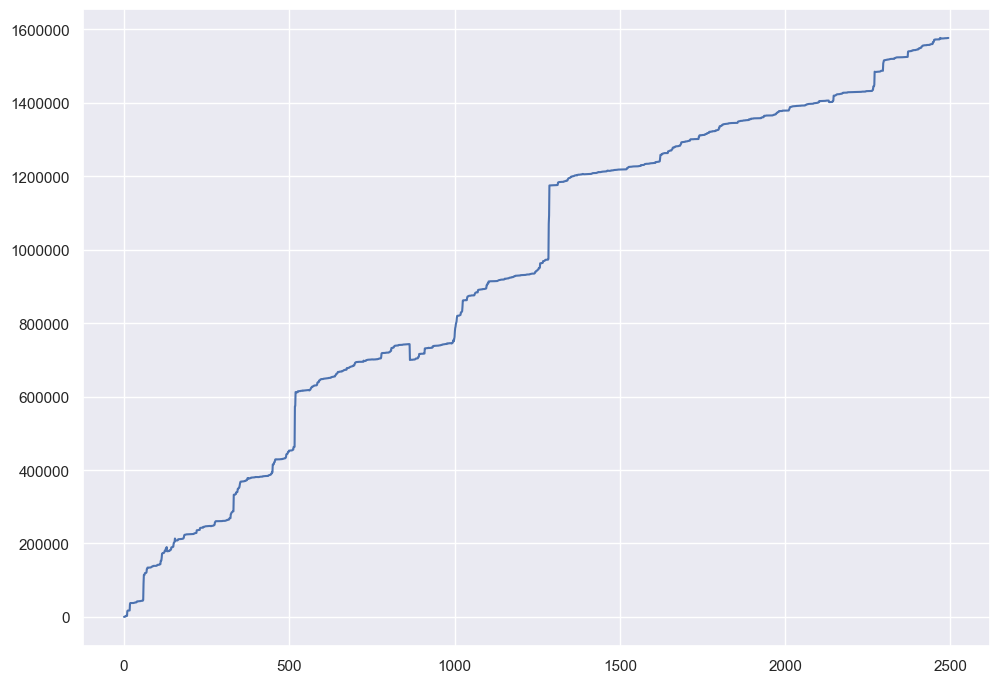

In [92]:
equity = 0
history = []
history.append(equity)

for i, x in trader_symbol_grouping.iterrows():
    _id = f"{x['LOGIN']}/{x['SYMBOL']}"
    if _id in badtraders1:
        equity += (-1 * x['PROFIT'])
        history.append(equity)

fig, ax = plt.subplots()
ax.plot(history)
ax.ticklabel_format(style='plain')
plt.show()

In [79]:
(len(history) / len(test)) * 100

2.2858451672010993

In [80]:
goodtraders1 = set()
for i, x in good_traders1.iterrows():
    _id = f'{i[0]}/{i[1]}'
    goodtraders1.add(_id)

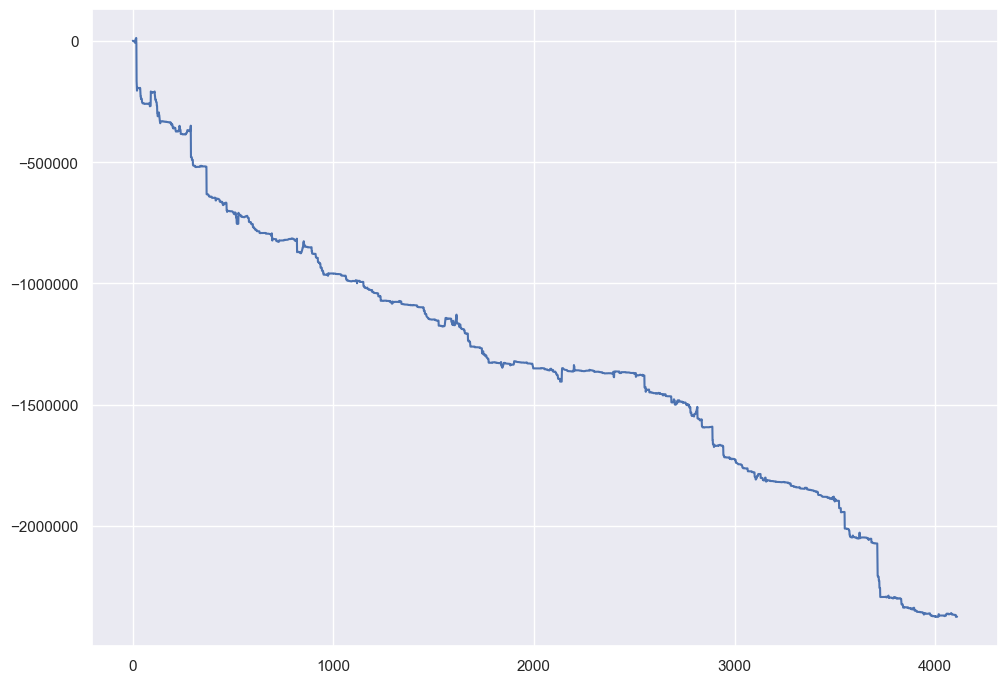

In [95]:
equity = 0
history = []
history.append(equity)

for i, x in trader_symbol_grouping.iterrows():
    _id = f"{x['LOGIN']}/{x['SYMBOL']}"
    if _id in goodtraders1:
        equity += (1 * x['PROFIT'])
        history.append(equity)
fig, ax = plt.subplots()
ax.plot(history)
ax.ticklabel_format(style='plain')
plt.show()

In [82]:
(len(history) / len(test)) * 100

3.7654603756298672